# Discrete sampling
In the last problem of the first session we sampled with given probabilities using prefix sums and binary search. The sampling code is the bottleneck of the whole process, its running times is 3 times higher than the code for uniform probabilities, and the difference would only increase for larger number of outcomes. In the next two problems we discuss two simple, but powerful techniques one can use to sample in time $O(1)$.

**Problem 2a.** Consider the problem of sampling with known probabilities $p_1,\ldots,p_d$. Suppose that you have a black-box that samples with probabilities $q_1,\ldots,q_d$ that are close to $p_1,\ldots,p_d$, say
$$ \forall_{i=1,\ldots,n} p_i \le (1+\varepsilon)q_i.$$

* How can you use this black-box to sample with probabilities $p_1,\ldots,p_d$? It is expected, that the running time of the algorithm would be non-deterministic.
* Prove that your algorithm is correct.
* Implement the algorithm and use it to give a faster implementation for **Problem 1c**.

In [2]:

import numpy as np
import matplotlib.pyplot as plt




In [3]:

def generate_bin_search(freq):
    def gen(count, freq):
        pref_sum = np.cumsum(freq)
        rand = np.random.randint(pref_sum[len(pref_sum) - 1], size=count)
        return np.searchsorted(pref_sum, rand)

    generated = gen(10000000, freq);
    unique_elements, gen_freq = np.unique(generated, return_counts=True)

    print("Generated")
    plt.plot(gen_freq/gen_freq.max())
    plt.show()
    print("Real")
    plt.plot(freq/freq.max())
    plt.show()


**Problem 2c (Squaring the histogram).** In this problem, we again want to sample with known probabilities $p_1,\ldots,p_n$, but this time we make no assumptions on $p_i$. Consider the following algorithm:
   * Let $V$ be the mean of $p_i$, i.e. $V=\frac{1}{n}$.
   * Create $n$ buckets, each with volume $V$, put each $p_i$ into a separate bucket.
   * Until there exists a bucket $A$ that is not full, find a bucket $B$ that overflows, and trasfer probability from $B$ to $A$ until $A$ is exactly full

Show that:
   * This algorithm always ends.
   * When it ends, each bucket contains pieces of exactly two $p_i$'s.

How to use the result of this algorithm to sample with probabilities $p_i$. Argue that your algorithm is correct and implement it. The sampling part should be *vectorized*. Use this algorithm to sample birthdates again, and test its efficiency.

mean =  189479.94086021505
Finished preprocessing
Generated


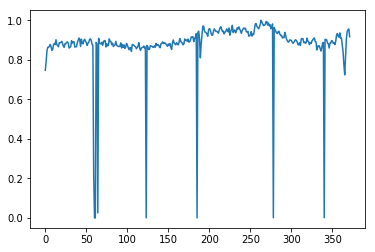

Real


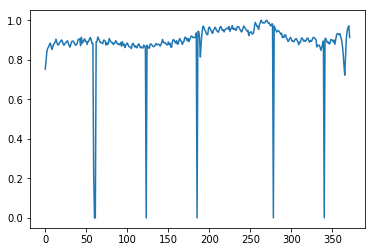

In [4]:
from bintrees import FastAVLTree

#pip install bintrees
def square_hist(data, generations):
    #Indices of properies stored in mutable 4-tuple
    POS = 0 
    H = 1
    MIX_POS = 2

    
    def vectorized_sample(count, squared, mean):
        mat = np.transpose(squared[np.random.randint(low = 0, high = len(squared), size=count)])
        R = mean * np.random.ranf(size = count)
        I = mat[POS]
        J = mat[MIX_POS]
        X = mat[H]
        D = X - R #difference of random value and height
        D = D / np.absolute(D) #Vec of -1s and 1s
        DI = (1 + D) / 2 #Vec of 1s and 0s where 1 denotes value from I
        DJ = 1 - DI #(negation of DI) Vec of 1s and 0s where 1 denotes value from J
        return (I * DI) + (J * DJ)
    
    
    def preprocess(data):
        mean = np.mean(data)
        print("mean = ", mean)
        tree = FastAVLTree()
        arr = []
        count = len(data)
        for i in range(0, count):
            tree.insert((data[i], i+1), [i, data[i], -1])
        while len(tree) >= 2:
            (k, maximal) = tree.pop_max()
            (k2, minimal) = tree.pop_min()
            if (minimal[H] < mean):
                diff = mean - minimal[H]
                minimal[MIX_POS] = maximal[POS]
                tree.insert((maximal[H] - diff, len(tree) + 1 ), [maximal[POS], maximal[H] - diff, -1])
            arr.append(minimal)
            
        if (len(tree) > 0):
            (k, last) = tree.pop_max()
            arr.append(last)
        print("Finished preprocessing")
        return np.array(arr)
    
    squared_hist = preprocess(data)
    generated = vectorized_sample(generations, squared_hist, np.mean(data))
    unique_elements, gen_freq = np.unique(generated, return_counts=True)
    print("Generated")
    plt.plot(gen_freq/gen_freq.max())
    plt.show()
    print("Real")
    plt.plot(data/data.max())
    plt.show()

data = np.genfromtxt('/Users/sme/Desktop/rpis/rpis2018/lab1/us_births_69_88.csv', delimiter=',')
freq = data[1:,2:]

square_hist(np.squeeze(np.asarray(freq)), 10000000)

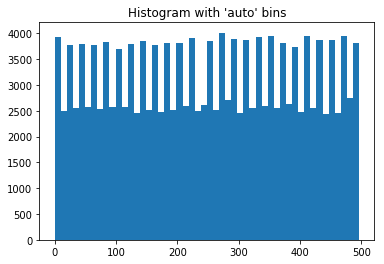

[  0.   4.   8.  12.  16.  20.  24.  28.  32.  36.  40.  44.  48.  52.
  56.  60.  64.  68.  72.  76.  80.  84.  88.  92.  96. 100. 104. 108.
 112. 116. 120. 124. 128. 132. 136. 140. 144. 148. 152. 156. 160. 164.
 168. 172. 176. 180. 184. 188. 192. 196. 200. 204. 208. 212. 216. 220.
 224. 228. 232. 236. 240. 244. 248. 252. 256. 260. 264. 268. 272. 276.
 280. 284. 288. 292. 296. 300. 304. 308. 312. 316. 320. 324. 328. 332.
 336. 340. 344. 348. 352. 356. 360. 364. 368. 372. 376. 380. 384. 388.
 392. 396. 400. 404. 408. 412. 416. 420. 424. 428. 432. 436. 440. 444.
 448. 452. 456. 460. 464. 468. 472. 476. 480. 484. 488. 492. 496.]
125


In [18]:
a = np.genfromtxt('/Users/sme/Desktop/rpis/rpis2018/lab2/hash_monitoring')
import matplotlib.pyplot as plt

plt.hist(a, bins=50)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

print(np.unique(a))
print(len(np.unique(a)))